Solving electro-magnetic equations for reflection from glass
==================================

In [2]:
import sys
import os
sys.path.append(os.path.dirname(os.getcwd()))
import macromax
from macromax import utils
from macromax import log
import logging
log.setLevel(logging.INFO)  # Comment this line to see more detailed messages

import numpy as np
import scipy.constants as const
import matplotlib.pyplot as plt
%matplotlib notebook

2019-04-17 10:17:13,142|MacroMax-INFO: Module pyfftw for FFTW not found, using numpy Fast Fourier transform instead.


## Define the material properties

In [3]:
wavelength = 500e-9
angular_frequency = 2 * const.pi * const.c / wavelength
source_amplitude = 1j * angular_frequency * const.mu_0
p_source = np.array([0, 1, 0])  # y-polarized

# Set the sampling grid
nb_samples = 1024
sample_pitch = wavelength / 16
x_range = sample_pitch * np.arange(nb_samples) - 4e-6

# define the medium
permittivity = np.ones((1, 1, len(x_range)), dtype=np.complex64)
# absorbing boundary
dist_in_boundary = np.maximum(-(x_range - -1e-6), x_range - 26e-6) / 4e-6
permittivity[:, :, (x_range < -1e-6) | (x_range > 26e-6)] =\
    1.0 + (0.8j * dist_in_boundary[(x_range < -1e-6) | (x_range > 26e-6)])
# glass has a refractive index of about 1.5
permittivity[:, :, (x_range >= 10e-6) & (x_range < 20e-6)] = 1.5 ** 2

## Define the source

In [4]:
source = -source_amplitude * sample_pitch * (np.abs(x_range) < sample_pitch/4)  # point source at 0
source = p_source[:, np.newaxis] * source[np.newaxis, :]

## Solve Maxwell's equations

In [5]:
# The actual work is done here:
solution = macromax.solve(x_range, vacuum_wavelength=wavelength, source_distribution=source, epsilon=permittivity)

2019-04-17 10:17:23,090|MacroMax-INFO: alpha = 1.481 + 0.769i, beta = 1
2019-04-17 10:17:23,095|MacroMax-INFO: Preparing pre-conditioned operators...


## Display results
* solution.E: Returns the electric field distribution.
* solution.H: Returns the magnetizing field distribution.
* solution.D: Returns the electric displacement field distribution.
* solution.B: Returns the magnetic flux density distribution.
* solution.S: The Poynting vector distribution in the sample.

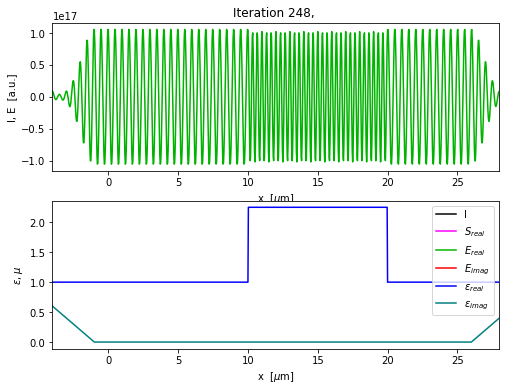

In [9]:
fig, ax = plt.subplots(2, 1, frameon=False, figsize=(8, 6))

x_range = solution.ranges[0]  # coordinates
E = solution.E[1, :]  # Electric field
H = solution.H[2, :]  # Magnetizing field
S = solution.S[0, :]  # Poynting vector
f = solution.f[0, :]  # Optical force
field_to_display = angular_frequency * E  # The source is polarized along this dimension
max_val_to_display = np.maximum(np.max(np.abs(field_to_display)), np.finfo(field_to_display.dtype).eps)
poynting_normalization = np.max(np.abs(S)) / max_val_to_display
#ax[0].plot(x_range * 1e6, np.abs(field_to_display) ** 2 / max_val_to_display, color=[0, 0, 0])[0]
#ax[0].plot(x_range * 1e6, np.real(S) / poynting_normalization, color=[1, 0, 1])[0]
ax[0].plot(x_range * 1e6, np.real(field_to_display), color=[0, 0.7, 0])[0]
#ax[0].plot(x_range * 1e6, np.imag(field_to_display), color=[1, 0, 0])[0]
figure_title = "Iteration %d, " % solution.iteration
ax[0].set_title(figure_title)
ax[0].set_xlabel("x  [$\mu$m]")
ax[0].set_ylabel("I, E  [a.u.]")
ax[0].set_xlim(x_range[[0, -1]] * 1e6)

ax[1].plot(x_range[-1] * 2e6, 0, color=[0, 0, 0], label='I')
ax[1].plot(x_range[-1] * 2e6, 0, color=[1, 0, 1], label='$S_{real}$')
ax[1].plot(x_range[-1] * 2e6, 0, color=[0, 0.7, 0], label='$E_{real}$')
ax[1].plot(x_range[-1] * 2e6, 0, color=[1, 0, 0], label='$E_{imag}$')
ax[1].plot(x_range * 1e6, permittivity[0, 0].real, color=[0, 0, 1], label='$\epsilon_{real}$')
ax[1].plot(x_range * 1e6, permittivity[0, 0].imag, color=[0, 0.5, 0.5], label='$\epsilon_{imag}$')
ax[1].set_xlabel('x  [$\mu$m]')
ax[1].set_ylabel('$\epsilon$, $\mu$')
ax[1].set_xlim(x_range[[0, -1]] * 1e6)
ax[1].legend(loc='upper right')